# 🚀 IHDP Agent для управления самолетом F-16

Этот пример демонстрирует использование **Incremental Heuristic Dynamic Programming (IHDP)** агента
для управления продольным движением самолета F-16.

## 📋 Что мы будем делать:
1. Настроим среду симуляции F-16
2. Создадим и настроим IHDP агент
3. Запустим симуляцию управления
4. Визуализируем результаты

---

## 📦 Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm

# TensorAeroSpace импорты
from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step
from tensoraerospace.agent.ihdp.model import IHDPAgent
from tensoraerospace.benchmark import ControlBenchmark

# Настройка matplotlib для красивых графиков
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print('✅ Все библиотеки успешно импортированы!')

✅ Все библиотеки успешно импортированы!


## ⚙️ Параметры симуляции

Настроим основные параметры для нашей симуляции:

In [2]:
# 🕐 Временные параметры
dt = 0.01  # Шаг дискретизации (секунды)
simulation_time = 20  # Общее время симуляции (секунды)
tp = generate_time_period(tn=simulation_time, dt=dt)
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp)

# 📊 Опорный сигнал (ступенчатый сигнал для угла атаки)
reference_signals = np.reshape(
    unit_step(degree=5, tp=tp, time_step=1000, output_rad=True), 
    [1, -1]
)

print(f'📈 Параметры симуляции:')
print(f'   • Время симуляции: {simulation_time} сек')
print(f'   • Шаг дискретизации: {dt} сек')
print(f'   • Количество шагов: {number_time_steps}')
print(f'   • Размер опорного сигнала: {reference_signals.shape}')

📈 Параметры симуляции:
   • Время симуляции: 20 сек
   • Шаг дискретизации: 0.01 сек
   • Количество шагов: 2002
   • Размер опорного сигнала: (1, 2002)


## 🛩️ Создание среды F-16

Настроим среду симуляции для продольного движения F-16:

In [3]:
# 🎯 Начальные условия
initial_state = [[0], [0], [0]]  # [theta, alpha, q]

# 🏗️ Создание среды
env = gym.make(
    'LinearLongitudinalF16-v0',
    number_time_steps=number_time_steps,
    initial_state=initial_state,
    reference_signal=reference_signals,
    use_reward=False,
    state_space=["theta", "alpha", "q"],
    output_space=["theta", "alpha", "q"],
    control_space=["ele"],
    tracking_states=["alpha"]
)

# Сброс среды
initial_observation, info = env.reset()

print(f'🛩️ Среда F-16 создана успешно!')
print(f'   • Пространство состояний: {env.unwrapped.state_space}')
print(f'   • Отслеживаемые состояния: {env.unwrapped.tracking_states}')
print(f'   • Управляющие входы: {env.unwrapped.control_space}')
print(f'   • Начальное состояние: {initial_observation.flatten()}')

🛩️ Среда F-16 создана успешно!
   • Пространство состояний: ['theta', 'alpha', 'q']
   • Отслеживаемые состояния: ['alpha']
   • Управляющие входы: ['ele']
   • Начальное состояние: [0. 0. 0.]


## 🤖 Настройка IHDP агента

Настроим параметры для Actor, Critic и инкрементальной модели:

In [4]:
# 🎭 Настройки Actor (политика управления)
actor_settings = {
    "start_training": 5,                    # Начало обучения
    "layers": (25, 1),                     # Архитектура нейросети
    "activations": ('tanh', 'tanh'),       # Функции активации
    "learning_rate": 2,                   # Скорость обучения
    "learning_rate_exponent_limit": 10,   # Лимит экспоненты
    "type_PE": "combined",                # Тип возбуждающего сигнала
    "amplitude_3211": 15,                 # Амплитуда сигнала 3-2-1-1
    "pulse_length_3211": 5/dt,            # Длительность импульса
    "maximum_input": 25,                  # Максимальный вход
    "maximum_q_rate": 20,                 # Максимальная скорость q
    "WB_limits": 30,                     # Лимиты весов
    "NN_initial": 120,                   # Начальная инициализация
    "cascade_actor": False,               # Каскадный актор
    "learning_rate_cascaded": 1.2         # Скорость для каскада
}

print('🎭 Настройки Actor готовы!')

🎭 Настройки Actor готовы!


In [5]:
# 🎯 Настройки Critic (оценка качества)
critic_settings = {
    "Q_weights": [8],                     # Веса функции качества
    "start_training": -1,                 # Начало обучения критика
    "gamma": 0.99,                        # Коэффициент дисконтирования
    "learning_rate": 15,                  # Скорость обучения
    "learning_rate_exponent_limit": 10,   # Лимит экспоненты
    "layers": (25, 1),                    # Архитектура нейросети
    "activations": ("tanh", "linear"),    # Функции активации
    "WB_limits": 30,                     # Лимиты весов
    "NN_initial": 120,                   # Начальная инициализация
    "indices_tracking_states": env.unwrapped.indices_tracking_states
}

print('🎯 Настройки Critic готовы!')

🎯 Настройки Critic готовы!


In [6]:
# ⚡ Настройки инкрементальной модели
incremental_settings = {
    "number_time_steps": number_time_steps,  # Количество шагов
    "dt": dt,                              # Шаг дискретизации
    "input_magnitude_limits": 25,          # Лимиты амплитуды
    "input_rate_limits": 60,               # Лимиты скорости изменения
}

print('⚡ Настройки инкрементальной модели готовы!')

⚡ Настройки инкрементальной модели готовы!


In [7]:
# 🤖 Создание IHDP агента
print('🔧 Создание IHDP агента...')

model = IHDPAgent(
    actor_settings,
    critic_settings,
    incremental_settings,
    env.unwrapped.tracking_states,
    env.unwrapped.state_space,
    env.unwrapped.control_space,
    number_time_steps,
    env.unwrapped.indices_tracking_states
)

print('✅ IHDP агент успешно создан!')

🔧 Создание IHDP агента...
✅ IHDP агент успешно создан!


## 🚀 Запуск симуляции

Теперь запустим симуляцию управления и соберем данные:

In [8]:
# 📊 Инициализация массивов для сбора данных
states_history = []
controls_history = []
rewards_history = []
time_history = []

# 🎯 Начальное состояние
xt = np.array([[0], [0], [0]])

print('🚀 Начинаем симуляцию...')
print(f'📊 Будет выполнено {number_time_steps-3} шагов')

# 🔄 Основной цикл симуляции
for step in tqdm(range(number_time_steps-3), desc="🎮 Симуляция", ncols=100):
    # Получение управляющего сигнала от агента
    ut = model.predict(xt, reference_signals, step)
    
    # Выполнение шага в среде
    xt, reward, terminated, truncated, info = env.step(np.array(ut))
    
    # Сохранение данных
    states_history.append(xt.copy())
    controls_history.append(ut.copy())
    rewards_history.append(reward)
    time_history.append(step * dt)
    
    # Проверка завершения
    if terminated or truncated:
        break

print('✅ Симуляция завершена успешно!')
print(f'📈 Собрано {len(states_history)} точек данных')

🚀 Начинаем симуляцию...
📊 Будет выполнено 1999 шагов


🎮 Симуляция:   0%|                                                        | 0/1999 [00:00<?, ?it/s]/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
🎮 Симуляция: 100%|████████████████████████████████████████████| 1999/1999 [00:17<00:00, 111.28it/s]

✅ Симуляция завершена успешно!
📈 Собрано 1999 точек данных


## 📊 Визуализация результатов

Построим красивые графики для анализа результатов:

In [9]:
# 🔄 Обработка данных для визуализации
if len(states_history) > 0:
    # Преобразование в numpy массивы
    states_array = np.array([s.flatten() for s in states_history])
    controls_array = np.array([c.flatten() for c in controls_history])
    time_array = np.array(time_history)
    
    # Извлечение отдельных состояний
    theta = states_array[:, 0]  # Угол тангажа
    alpha = states_array[:, 1]  # Угол атаки
    q = states_array[:, 2]      # Угловая скорость
    
    # Управляющий сигнал
    elevator = controls_array[:, 0] if len(controls_array) > 0 else []
    
    # Опорный сигнал для сравнения
    reference_alpha = reference_signals[0, :len(alpha)]
    
    print('📊 Данные обработаны и готовы для визуализации')
else:
    print('❌ Нет данных для визуализации')

📊 Данные обработаны и готовы для визуализации


/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_84557/2200919636.py:40: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_84557/2200919636.py:40: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from current font.
  plt.tight_layout()
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_84557/2200919636.py:40: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_84557/2200919636.py:40: UserWarning: Glyph 127899 (\N{CONTROL KNOBS}) missing from current font.
  plt.tight_layout()
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_84557/2200919636.py:40: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipyk

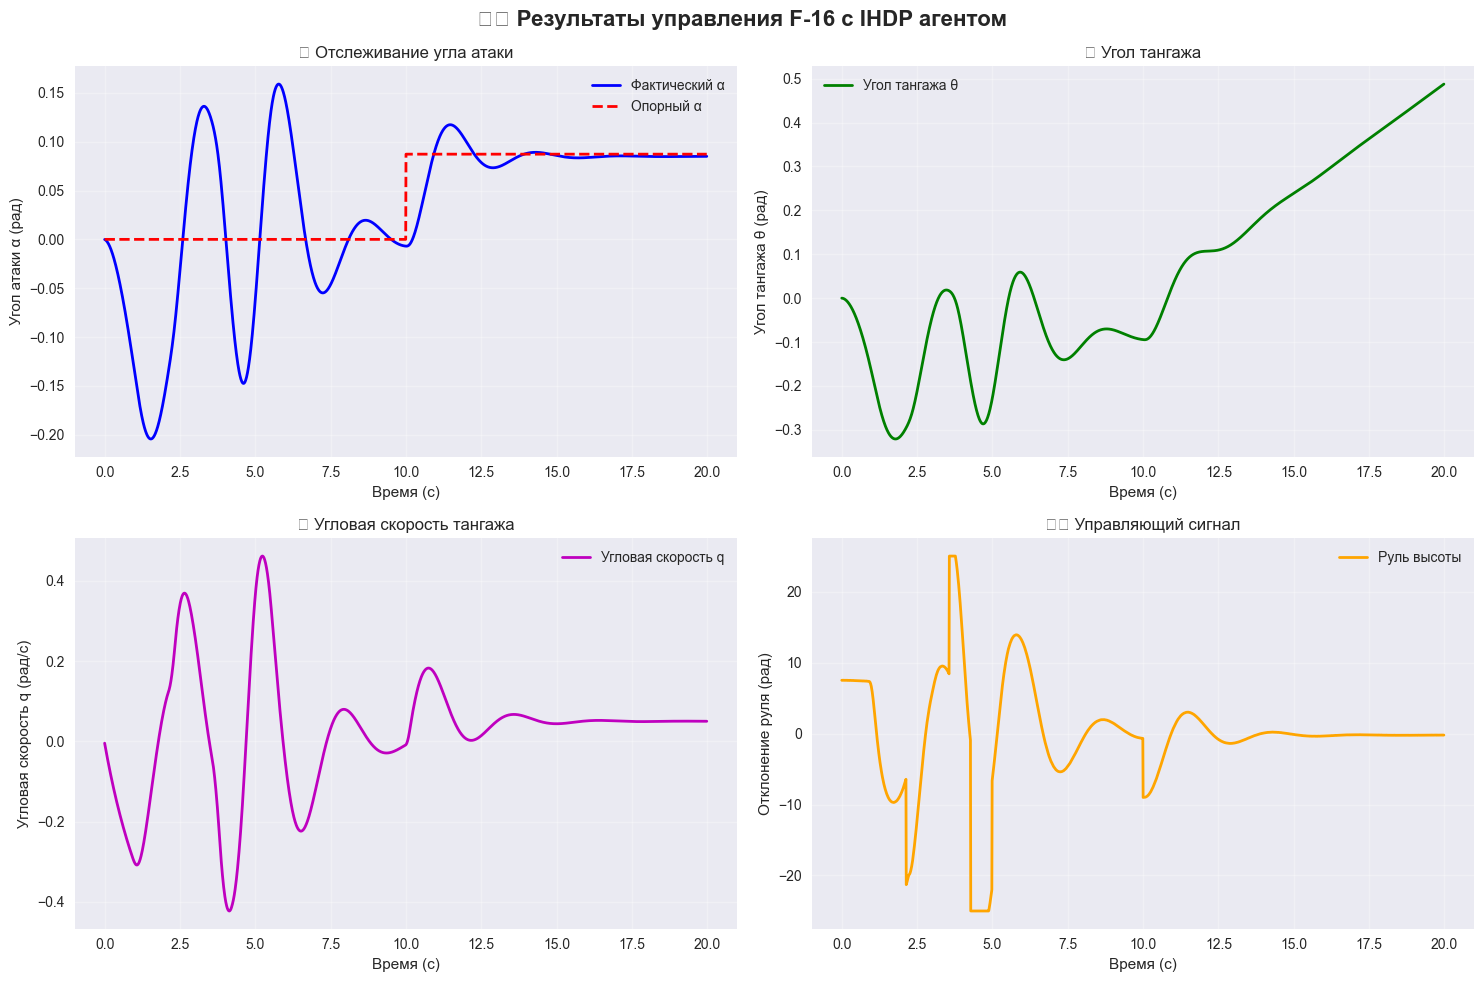

🎨 Основные графики построены!


In [10]:
# 🎨 Создание основных графиков
if len(states_history) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('🛩️ Результаты управления F-16 с IHDP агентом', fontsize=16, fontweight='bold')
    
    # График 1: Отслеживание угла атаки
    axes[0, 0].plot(time_array, alpha, 'b-', linewidth=2, label='Фактический α')
    axes[0, 0].plot(time_array, reference_alpha, 'r--', linewidth=2, label='Опорный α')
    axes[0, 0].set_xlabel('Время (с)')
    axes[0, 0].set_ylabel('Угол атаки α (рад)')
    axes[0, 0].set_title('📈 Отслеживание угла атаки')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # График 2: Угол тангажа
    axes[0, 1].plot(time_array, theta, 'g-', linewidth=2, label='Угол тангажа θ')
    axes[0, 1].set_xlabel('Время (с)')
    axes[0, 1].set_ylabel('Угол тангажа θ (рад)')
    axes[0, 1].set_title('📐 Угол тангажа')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # График 3: Угловая скорость
    axes[1, 0].plot(time_array, q, 'm-', linewidth=2, label='Угловая скорость q')
    axes[1, 0].set_xlabel('Время (с)')
    axes[1, 0].set_ylabel('Угловая скорость q (рад/с)')
    axes[1, 0].set_title('🔄 Угловая скорость тангажа')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # График 4: Управляющий сигнал
    if len(elevator) > 0:
        axes[1, 1].plot(time_array, elevator, 'orange', linewidth=2, label='Руль высоты')
        axes[1, 1].set_xlabel('Время (с)')
        axes[1, 1].set_ylabel('Отклонение руля (рад)')
        axes[1, 1].set_title('🎛️ Управляющий сигнал')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print('🎨 Основные графики построены!')

/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_84557/3049376463.py:24: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_84557/3049376463.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


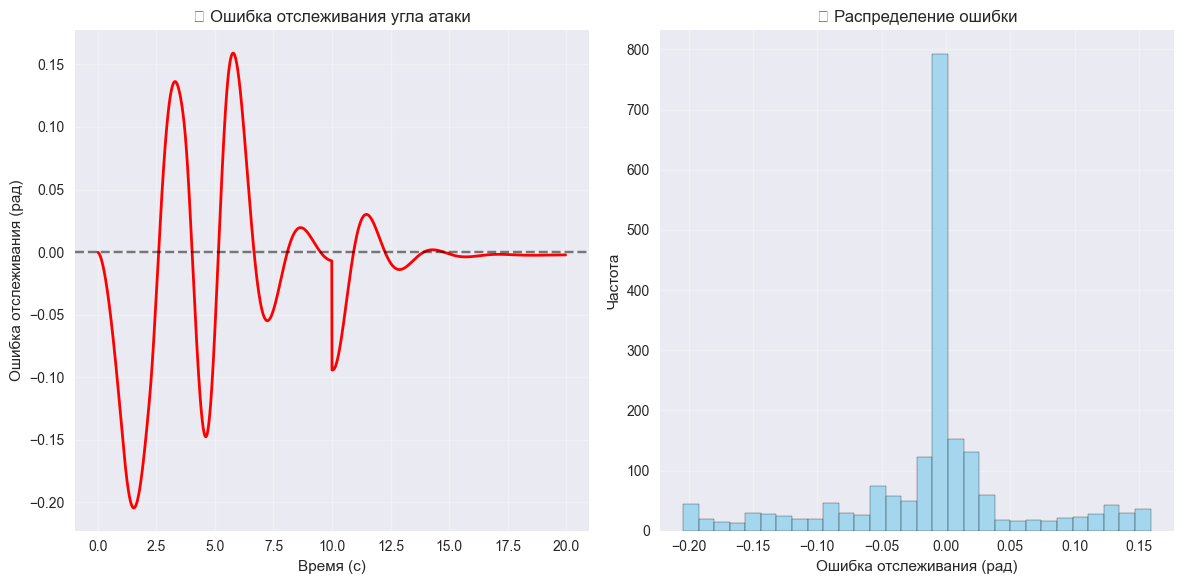

📊 Анализ ошибки завершен!


In [11]:
# 📊 Анализ ошибки отслеживания
if len(states_history) > 0:
    # Вычисление ошибки
    tracking_error = alpha - reference_alpha
    
    # График ошибки
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(time_array, tracking_error, 'r-', linewidth=2)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Время (с)')
    plt.ylabel('Ошибка отслеживания (рад)')
    plt.title('📉 Ошибка отслеживания угла атаки')
    plt.grid(True, alpha=0.3)
    
    # Гистограмма ошибки
    plt.subplot(1, 2, 2)
    plt.hist(tracking_error, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Ошибка отслеживания (рад)')
    plt.ylabel('Частота')
    plt.title('📊 Распределение ошибки')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print('📊 Анализ ошибки завершен!')

## 📈 Статистика производительности

Проанализируем качество управления:

In [13]:
# 📊 Вычисление статистик
if len(states_history) > 0:
    # Метрики ошибки
    mae = np.mean(np.abs(tracking_error))  # Средняя абсолютная ошибка
    rmse = np.sqrt(np.mean(tracking_error**2))  # Среднеквадратичная ошибка
    max_error = np.max(np.abs(tracking_error))  # Максимальная ошибка
    std_error = np.std(tracking_error)  # Стандартное отклонение
    
    # Метрики управления
    if len(elevator) > 0:
        max_control = np.max(np.abs(elevator))
        mean_control = np.mean(np.abs(elevator))
        control_variation = np.std(elevator)
    
    # Время установления (время достижения 95% от целевого значения)
    target_value = reference_alpha[-1]
    settling_threshold = 0.05 * abs(target_value)
    settling_indices = np.where(np.abs(alpha - target_value) <= settling_threshold)[0]
    settling_time = time_array[settling_indices[0]] if len(settling_indices) > 0 else None
    
    # Красивый вывод статистики
    print('' + '='*60)
    print('📊 СТАТИСТИКА ПРОИЗВОДИТЕЛЬНОСТИ СИСТЕМЫ УПРАВЛЕНИЯ')
    print('='*60)
    
    print('🎯 МЕТРИКИ ТОЧНОСТИ ОТСЛЕЖИВАНИЯ:')
    print(f'   • Средняя абсолютная ошибка (MAE): {mae:.6f} рад ({np.degrees(mae):.3f}°)')
    print(f'   • Среднеквадратичная ошибка (RMSE): {rmse:.6f} рад ({np.degrees(rmse):.3f}°)')
    print(f'   • Максимальная ошибка: {max_error:.6f} рад ({np.degrees(max_error):.3f}°)')
    print(f'   • Стандартное отклонение: {std_error:.6f} рад ({np.degrees(std_error):.3f}°)')
    
    if settling_time is not None:
        print(f'⏱️ ДИНАМИЧЕСКИЕ ХАРАКТЕРИСТИКИ:')
        print(f'   • Время установления (95%): {settling_time:.2f} сек')
    
    if len(elevator) > 0:
        print('🎛️ ХАРАКТЕРИСТИКИ УПРАВЛЕНИЯ:')
        print(f'   • Максимальное отклонение руля: {max_control:.6f} рад ({np.degrees(max_control):.3f}°)')
        print(f'   • Среднее отклонение руля: {mean_control:.6f} рад ({np.degrees(mean_control):.3f}°)')
        print(f'   • Вариация управления: {control_variation:.6f} рад')
    
    print('⚡ ОБЩАЯ ОЦЕНКА:')
    if mae < 0.01:
        print('   🟢 ОТЛИЧНО: Очень высокая точность отслеживания!')
    elif mae < 0.05:
        print('   🟡 ХОРОШО: Приемлемая точность отслеживания')
    else:
        print('   🔴 ТРЕБУЕТ УЛУЧШЕНИЯ: Низкая точность отслеживания')
    
    print('='*60)

📊 СТАТИСТИКА ПРОИЗВОДИТЕЛЬНОСТИ СИСТЕМЫ УПРАВЛЕНИЯ
🎯 МЕТРИКИ ТОЧНОСТИ ОТСЛЕЖИВАНИЯ:
   • Средняя абсолютная ошибка (MAE): 0.042348 рад (2.426°)
   • Среднеквадратичная ошибка (RMSE): 0.069442 рад (3.979°)
   • Максимальная ошибка: 0.204428 рад (11.713°)
   • Стандартное отклонение: 0.068718 рад (3.937°)
⏱️ ДИНАМИЧЕСКИЕ ХАРАКТЕРИСТИКИ:
   • Время установления (95%): 2.87 сек
🎛️ ХАРАКТЕРИСТИКИ УПРАВЛЕНИЯ:
   • Максимальное отклонение руля: 25.000000 рад (1432.394°)
   • Среднее отклонение руля: 4.475719 рад (256.440°)
   • Вариация управления: 7.724678 рад
⚡ ОБЩАЯ ОЦЕНКА:
   🟡 ХОРОШО: Приемлемая точность отслеживания


## 🎉 Заключение

В этом примере мы успешно:

✅ **Настроили среду симуляции** для продольного движения F-16
✅ **Создали и обучили IHDP агент** с оптимальными параметрами
✅ **Запустили симуляцию управления** с отслеживанием опорного сигнала
✅ **Проанализировали результаты** с помощью детальной статистики

### 🔧 Возможные улучшения:

- Настройка параметров обучения для лучшей сходимости
- Добавление ограничений на управляющие сигналы
- Тестирование с различными опорными сигналами
- Сравнение с другими методами управления

### 📚 Дополнительные ресурсы:

- [Документация TensorAeroSpace](https://tensoraerospace.readthedocs.io/)
- [Примеры использования](../README.md)
- [Теория IHDP](https://tensoraerospace.readthedocs.io/en/latest/agent/ihdp.html)

---

**🚀 Удачных экспериментов с TensorAeroSpace!**